https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html



https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

In [2]:
import numpy as np
import pandas as pd
import icecream
import math
import sklearn
import os
import gc
import random
import re
import csv
import spacy

from itertools import *
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import sklearn.metrics as metrics
from tempfile import TemporaryDirectory
from typing import Tuple

import matplotlib.pyplot as plt
import seaborn as sns
from captum.attr._core.layer.layer_activation import LayerActivation
from PIL import Image
from wordcloud import WordCloud
import pickle
from sklearn.metrics import silhouette_score
from nltk.corpus import wordnet
from sklearn.metrics import davies_bouldin_score


C:\Users\salma\anaconda3\envs\env-gpu-10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
classification = "pos"

In [29]:
import nltk
from nltk.corpus import stopwords
 
# nltk.download('stopwords')
stop = stopwords.words('english')
print(len(stop))

179


### Helpers

In [31]:
def dict_with_tuple_keys_to_csv(data, output_file):
    """
    Convert a dictionary with tuple keys and dictionary values to a CSV file.
    
    Parameters:
    -----------
    data : dict
        A dictionary where keys are tuples and values are dictionaries.
        Example: {('A', 'B'): {'score': 90, 'grade': 'A'}, ('C', 'D'): {'score': 85, 'grade': 'B'}}
    
    output_file : str
        Path to the output CSV file.
    """
    # Check if data is empty
    if not data:
        print("Empty dictionary provided.")
        return
    
    # Get all possible column names from all inner dictionaries
    columns = set()
    for inner_dict in data.values():
        columns.update(inner_dict.keys())
    
    # Determine the number of elements in tuple keys
    sample_key = next(iter(data.keys()))
    tuple_length = len(sample_key)
    
    # Create headers: tuple element names (key1, key2, ...) followed by column names
    tuple_headers = [f"key{i+1}" for i in range(tuple_length)]
    headers = tuple_headers + list(columns)
    
    with open(output_file, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=headers)
        writer.writeheader()
        
        # Write each row
        for tuple_key, inner_dict in data.items():
            row = {}
            
            # Add tuple elements to the row
            for i, element in enumerate(tuple_key):
                row[tuple_headers[i]] = element
            
            # Add values from inner dictionary
            row.update(inner_dict)
            
            writer.writerow(row)
    
    print(f"Data successfully written to {output_file}")


In [32]:
def save_wordclouds(df_no_stop, location):
    try:
        os.makedirs(location)
        print(f"Directory '{location}' created successfully.")
    except FileExistsError:
        print(f"Directory '{location}' already exists.")
    except OSError as e:
        print(f"Error creating directory '{location}': {e}")

    try:
        os.makedirs(f"{location}/small")
        print(f"Directory '{location}' created successfully.")
    except FileExistsError:
        print(f"Directory '{location}' already exists.")
    except OSError as e:
        print(f"Error creating directory '{location}': {e}")
    clusternums = df_no_stop['cluster'].unique()
    for clus in clusternums:



        words = list(df_no_stop['token'][df_no_stop['cluster']==clus])
        try:
            if len(words)>0:
                # print(len(words))
                wc = WordCloud(collocations=False, background_color="white").generate(" ".join(words))
                plt.figure(figsize=(7, 4), facecolor=None)
                plt.title(f"cluster no.: {clus} , size: {len(words)}")
                plt.xticks([])
                plt.yticks([])
                plt.imshow(wc)
                if len(words)>10:
                    plt.savefig(f"{location}/clus_{clus}")
                else:
                    plt.savefig(f"{location}/small/clus_{clus}")

                plt.close()
                # break
        except:
            print(words)

In [33]:
def run_clustering(data, required_cluster_number, required_linkage, required_metric):
    clustering = AgglomerativeClustering(n_clusters=required_cluster_number, linkage=required_linkage, memory="D:/salma/_MSc/Lab/ConceptExplanations/agg_cache",metric =required_metric, compute_distances=True).fit(data)
    # clustering.labels_
    return clustering

## Load Data

In [34]:

if classification =="pos":
    #Then, to reload:
    act_df= pd.read_csv(f"attribution_results/padding_removed/suicide11/batch{0}.csv")
    for i, f in enumerate(os.listdir()):
        if i>0:
            act_df=pd.concat([act_df, pd.read_csv(f"attribution_results/padding_removed/suicide11/batch{i}.csv")], ignore_index=True)
            print(act_df.shape)
    act_df.head(2)

if classification =="neg":
    #Then, to reload:
    act_df= pd.read_csv(f"attribution_results/padding_removed/non-suicide11/batch{0}.csv")
    for i, f in enumerate(os.listdir()):
        if i>0:
            act_df=pd.concat([act_df, pd.read_csv(f"attribution_results/padding_removed/non-suicide11/batch{i}.csv")], ignore_index=True)
            print(act_df.shape)
    act_df.head(2)
act_df.dropna(inplace=True)

(11913, 769)
(18275, 769)
(26127, 769)
(32553, 769)
(40848, 769)
(48334, 769)
(54671, 769)
(61925, 769)
(70378, 769)
(78165, 769)
(83353, 769)
(91252, 769)
(96329, 769)
(101022, 769)
(107824, 769)
(114629, 769)
(123699, 769)
(131607, 769)
(138771, 769)
(145661, 769)
(152902, 769)
(158114, 769)
(164857, 769)
(171399, 769)
(179045, 769)
(185462, 769)
(191596, 769)
(196227, 769)
(202946, 769)
(208828, 769)
(215349, 769)
(222235, 769)
(229534, 769)
(237774, 769)
(242961, 769)
(251169, 769)
(257858, 769)
(264659, 769)
(272863, 769)
(280086, 769)
(288019, 769)
(293775, 769)
(299265, 769)
(305348, 769)
(311287, 769)


#### Reconstruct sentences


In [35]:
cls_idxs = act_df[act_df['token']=='[CLS]'].index
sep_idxs = act_df[act_df['token']=='[SEP]'].index
sentences = " ".join(act_df['token']).split('[CLS]')


In [36]:
for (i, (j, k)) in enumerate(zip(cls_idxs, sep_idxs)):
    act_df.loc[j:k, 'sentence'] = sentences[i+1]


In [37]:
act_df.drop(act_df['token'][map((lambda x: ("[" in x) or ("#" in x) or (any([a not in "qwertyuiopasdfghjklzxcvbnm"for a in x]) )), act_df['token'])].index, axis=0, inplace=True)
print(f"act_df shape: {act_df.shape}")
print(f"number of stop tokens {sum(act_df['token'].map((lambda x: x in stop)))}")

act_df shape: (256097, 770)
number of stop tokens 146740


In [38]:
#drop stop words

df_no_stop = act_df[act_df['token'].map((lambda x: x not in stop))]
# df_no_stop = act_df
df_no_stop.head(2)


,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,token,sentence
1,0.092361,0.537579,-0.108185,-0.369392,0.656724,1.118478,-0.146349,-0.118915,0.962345,-1.016192,...,0.794478,0.525619,-0.005307,-0.348388,0.378788,0.571991,0.303386,0.014218,every,every little problem makes me want to kill my...
2,0.023838,0.095783,-0.089390,-0.010807,0.186203,0.555168,0.653269,-0.773034,-0.557048,-0.434466,...,0.196344,-0.067425,-0.322750,-0.682568,-0.405120,-0.133127,0.074864,-0.234065,little,every little problem makes me want to kill my...


In [39]:
df_no_stop['token'].value_counts()

token
like           1384
want           1345
feel           1206
life           1200
know           1043
               ... 
depending         1
evidently         1
drastically       1
testament         1
judging           1
Name: count, Length: 7204, dtype: int64

In [40]:
df_no_stop.shape

(109357, 770)

In [41]:
df_no_stop = df_no_stop.iloc[:50000]

In [42]:
X = np.array(df_no_stop.drop(['token', 'sentence'], axis=1))
X.shape

(50000, 768)

#### Cleaning

In [43]:
gc.collect()

185

In [21]:
del act_df

In [22]:
gc.collect()

0

# Clustering and saving wordclouds

In [65]:



result_dict = {}
# result_dict_no_outliers = {}

for required_cluster_number in range(400, 401, 100):
# required_cluster_number = 500
    required_linkage = 'average'
    required_metric = 'cosine'
    clustering = run_clustering(X, required_cluster_number, required_linkage, required_metric)
    print(f"label bincounts: {(np.bincount(clustering.labels_))}")

    model_file = f'agg_models/agg_{classification}_50000_{required_metric}_{required_linkage}_{required_cluster_number}.pkl'
    # #save model
    with open(model_file,'wb') as f:
        pickle.dump(clustering,f)

    # load model
    with open(model_file, 'rb') as f:
        clf2 = pickle.load(f)

    clf2.get_params()
    label_counts = np.bincount(clf2.labels_)
    # plt.hist(np.bincount(clf2.labels_))

    df_no_stop.loc[:,'cluster']= list(clf2.labels_)

    wordclouds_folder = f"word_clouds/{classification}/{required_metric}/{required_linkage}/{required_cluster_number}/white"
    if (required_cluster_number==600):
        save_wordclouds(df_no_stop=df_no_stop, location = wordclouds_folder)

    df_no_stop.to_csv("positive_concepts_agg_{required_metric}_{required_linkage}_{required_cluster_number}.csv")

    scores = {}

    silhouette = silhouette_score(np.array(df_no_stop.drop(['token', 'sentence','cluster'], axis=1)), np.array(df_no_stop['cluster']), metric='cosine')
    scores['silhouette'] = silhouette

    calinski_harabasz = metrics.calinski_harabasz_score(np.array(df_no_stop.drop(['token','sentence', 'cluster'], axis=1)), np.array(df_no_stop['cluster']))
    scores['calinski_harabasz'] = calinski_harabasz

    davies_bouldin = davies_bouldin_score(df_no_stop.drop(['token',	'sentence'	,'cluster'], axis=1), df_no_stop['cluster'])
    scores['davies_bouldin'] = davies_bouldin


    result_dict[(required_metric, required_linkage, required_cluster_number, "all")] = scores
    


    scores = {}

    df_no_outliers = df_no_stop.copy()
    outlier_clusters = [i for i, element in enumerate(label_counts) if element < 10]
    df_no_outliers = df_no_outliers[~df_no_outliers['cluster'].isin(outlier_clusters)]


    silhouette = silhouette_score(np.array(df_no_outliers.drop(['token', 'sentence', 'cluster'], axis=1)), np.array(df_no_outliers['cluster']), metric='cosine')
    scores['silhouette'] = silhouette

    calinski_harabasz = metrics.calinski_harabasz_score(np.array(df_no_outliers.drop(['token','sentence', 'cluster'], axis=1)), np.array(df_no_outliers['cluster']))
    scores['calinski_harabasz'] = calinski_harabasz

    davies_bouldin = davies_bouldin_score(np.array(df_no_outliers.drop(['token', 'sentence', 'cluster'], axis=1)), np.array(df_no_outliers['cluster']))
    scores['davies_bouldin'] = davies_bouldin
    
    
    result_dict[(required_metric, required_linkage, required_cluster_number, "no_outliers")] = scores

    dict_with_tuple_keys_to_csv(result_dict, f'clustering_results/scores{classification}_{required_metric}_{required_linkage}_{required_cluster_number}.csv')
    
    



label bincounts: [ 214 1292  509   64    6    2 1145   62  392 1757    5  591 1580   22
   21    4    9  518  114   18   59    9  248    9   29  102   12  118
   31    5  150    6  120   52   98   73   15   72   45   43  192   18
  188   27   45   39  110   65   13   42  224   10  100   30   19  226
  170  414   41   10    7   74   21   28  809   14   11   96   66   14
   96  244    5  154   32   13   57    7   79   17   29  106   14   62
  203    9  543   29  151  229  484    8   40  340   15  153  204   16
   59   19   15   18   69  140   75   64   65   73    4    5    6   32
   19   56    4   18    5   27  248    4  334    6   25   79    6  214
    9  146   12   35   23   45   17   22   36   57   11    6  655  753
   59  295   11   26   23    4   27   18   42  612  521   53  203   18
   81   25   78    5  142  161    7   12   50   10   38   49    4   73
   20   25   17   93   11   58    7   11   21   16   11    3   50  568
   14   11   30    4    8   19  825    4   91  103   14   23

In [39]:
print(result_dict)

{('cosine', 'average', 300, 'all'): {'silhouette': 0.04538617476807869, 'calinski_harabasz': 21.2298507238001}, ('cosine', 'average', 300, 'no_outliers'): {'silhouette': 0.05420073625659939, 'calinski_harabasz': 29.416838397187675}, ('cosine', 'average', 400, 'all'): {'silhouette': 0.052550925848595595, 'calinski_harabasz': 18.392189709785924}, ('cosine', 'average', 400, 'no_outliers'): {'silhouette': 0.06208251989912449, 'calinski_harabasz': 27.285770336082575}, ('cosine', 'average', 500, 'all'): {'silhouette': 0.0645317957352673, 'calinski_harabasz': 16.87942582029269}, ('cosine', 'average', 500, 'no_outliers'): {'silhouette': 0.07434684298424453, 'calinski_harabasz': 25.731037381904095}}


In [ ]:
# {('cosine', 'average', 100): {"silhouette":-0.027948061538660595, "Homogeneity":0.233354, "V-measure":0.751966}, ('cosine', 'average', 200): {"silhouette":-0.027948061538660595, "Homogeneity":0.233354, "V-measure":0.751966}, ('cosine', 'average', 300): {"silhouette":-0.027948061538660595, "Homogeneity":0.233354, "V-measure":0.751966}}

### Plotting Results

In [21]:
stats_file_pos = f"clustering_results/non pca/scorespos_cosine_average_1000.csv"
stats_df_pos = pd.read_csv(stats_file_pos)
stats_df_pos["Class"]=1
# stats_df_pos.head()
stats_file_neg = f"clustering_results/non pca/scoresneg_cosine_average_1000.csv"
stats_df_neg = pd.read_csv(stats_file_neg)
stats_df_neg['Class'] = 0
# stats_df_pos.head()
stats_df = pd.concat([stats_df_pos, stats_df_neg])
stats_df.rename(columns={"key1": "distance", "key2": "linkage", "key3": "n_clusters", "key4": "outliers"}, inplace=True)
stats_df.head()

,distance,linkage,n_clusters,outliers,calinski_harabasz,silhouette,davies_bouldin,Class
0,cosine,average,100,all,15.019905,-0.027948,3.459077,1
1,cosine,average,100,no_outliers,21.014720,-0.020082,4.007835,1
2,cosine,average,200,all,18.660441,-0.021242,3.258186,1
3,cosine,average,200,no_outliers,28.211417,-0.010243,3.857714,1
4,cosine,average,300,all,18.150408,-0.015369,3.082583,1


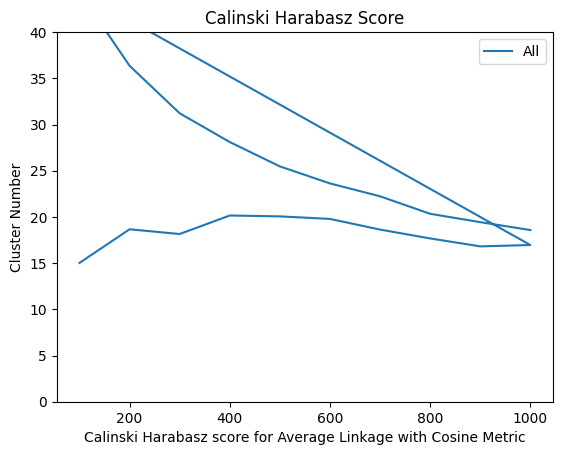

In [23]:

plt.plot(stats_df[stats_df["outliers"]=="all"]["n_clusters"], stats_df[stats_df["outliers"]=="all"]["calinski_harabasz"])
# plt.plot(stats_df[stats_df["outliers"]=="no_outliers"]["n_clusters"], stats_df[stats_df["outliers"]=="no_outliers"]["calinski_harabasz"])

plt.xlabel("Calinski Harabasz score for Average Linkage with Cosine Metric") 
plt.ylabel("Cluster Number") 
plt.title("Calinski Harabasz Score") 
plt.ylim(0, 40)
plt.legend(["All", "No outliers"])
plt.show()

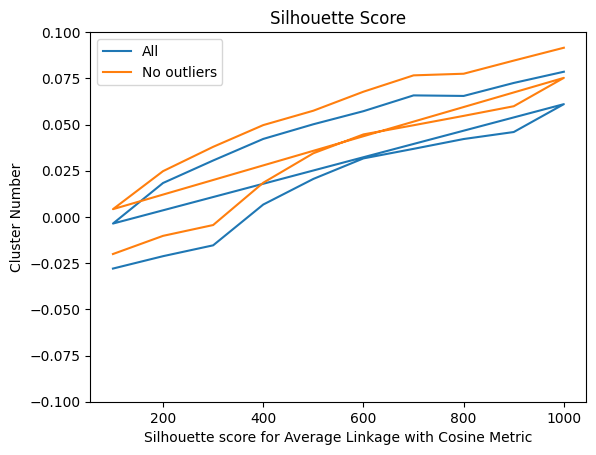

In [ ]:
# plt.plot(stats_df[stats_df["outliers"]=="all"]["n_clusters"], stats_df[stats_df["outliers"]=="all"]["silhouette"])
# plt.plot(stats_df[stats_df["outliers"]=="no_outliers"]["n_clusters"], stats_df[stats_df["outliers"]=="no_outliers"]["silhouette"])
# plt.xlabel("Silhouette score for Average Linkage with Cosine Metric") 
# plt.ylabel("Cluster Number") 
# plt.ylim(-0.1, 0.1)
# plt.title("Silhouette Score") 
# plt.legend(["All", "No outliers"])
# plt.show()

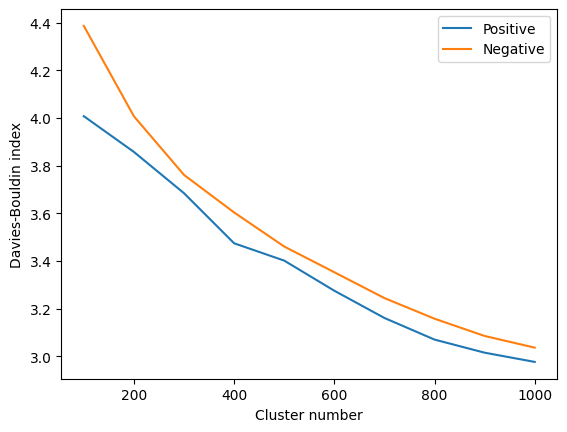

In [37]:
plt.plot(stats_df[(stats_df['outliers'] == 'no_outliers') & (stats_df['Class'] == 1)]["n_clusters"], stats_df[(stats_df['outliers'] == 'no_outliers') & (stats_df['Class'] == 1)]["davies_bouldin"])
plt.plot(stats_df[(stats_df['outliers'] == 'no_outliers') & (stats_df['Class'] == 1)]["n_clusters"], stats_df[(stats_df['outliers'] == 'no_outliers') & (stats_df['Class'] == 0)]["davies_bouldin"])
plt.ylabel("Davies-Bouldin index") 
plt.xlabel("Cluster number") 
# plt.ylim(-0.1, 0.1)
# plt.title("Silhouette Score per Class") 
plt.legend(["Positive", "Negative"])
plt.show()

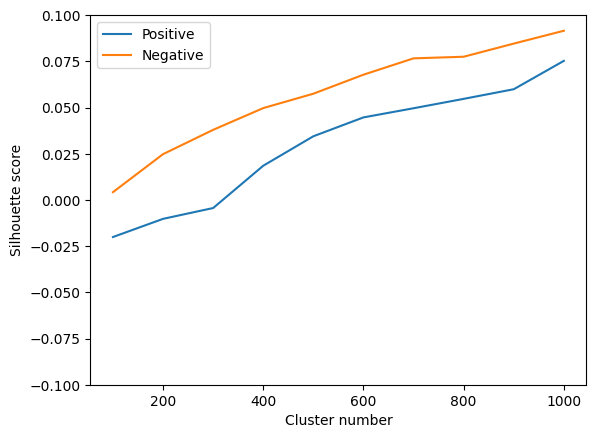

In [38]:
plt.plot(stats_df[(stats_df['outliers'] == 'no_outliers') & (stats_df['Class'] == 1)]["n_clusters"], stats_df[(stats_df['outliers'] == 'no_outliers') & (stats_df['Class'] == 1)]["silhouette"])
plt.plot(stats_df[(stats_df['outliers'] == 'no_outliers') & (stats_df['Class'] == 1)]["n_clusters"], stats_df[(stats_df['outliers'] == 'no_outliers') & (stats_df['Class'] == 0)]["silhouette"])
# plt.plot(stats_df[stats_df["outliers"]=="no_outliers"]["n_clusters"], stats_df[stats_df["outliers"]=="no_outliers"]["silhouette"])
plt.ylabel("Silhouette score") 
plt.xlabel("Cluster number") 
plt.ylim(-0.1, 0.1)
# plt.title("Silhouette Score per Class") 
plt.legend(["Positive", "Negative"])
plt.show()

In [ ]:
# from wn import taxonomy
# from wn.similarity import lch
# ewn = wn.Wordnet('ewn:2020')
# n_depth = wn.taxonomy.taxonomy_depth(ewn, 'n')
# spatula = ewn.synsets('spatula')[0]
# lch(spatula, ewn.synsets('pancake')[0], n_depth)
# lch(spatula, ewn.synsets('utensil')[0], n_depth)
# lch(spatula, spatula, n_depth)
# v_depth = taxonomy.taxonomy_depth(ewn, 'v')
# flip = ewn.synsets('flip', pos='v')[0]
# turn_over = ewn.synsets('turn over', pos='v')[0]
# lch(flip, turn_over, v_depth, simulate_root=True)

NameError: name 'wn' is not defined

#### Evaluating the clusters

no need to compare clusters or assess them, this will be carried out by TCAV.

next step is to get concept samples for each cluster

In [ ]:
clus= 20
words = list(df_no_stop['token'][df_no_stop['cluster']==clus])
print(len(words))
print(len(words))

wc = WordCloud().generate(" ".join(words))
plt.title(f"cluster no.: {clus} , size: {len(words)}")
plt.imshow(wc)
plt.savefig(f"{classification}_agg_clouds/clus_{clus}")
# break

In [19]:
# average linkage, cosine distance
# 400 clusters: 
# 500 clusters: 0.02056
# 600 clusters: 
# 700 clusters: 

ward linkage
400 clusters: 0.03064
500 clusters: 0.034933
600 clusters: 0.037800
700 clusters: 0.04112

ward linkage, squared euclidean distance
400 clusters: 
500 clusters: 0.05769
600 clusters: 
700 clusters: 

## Clustering With PCA

In [23]:
from sklearn.decomposition import PCA

In [77]:
pca = PCA(n_components=200)
pca.fit(X)

PCA(n_components=200)

In [79]:
print(pca.explained_variance_ratio_)

[0.03333052 0.02352036 0.01944407 0.01837326 0.0175719  0.0150893
 0.01427264 0.01263993 0.01226288 0.01176909 0.01155733 0.01126266
 0.01077401 0.01043461 0.0098326  0.00964468 0.0089294  0.00877901
 0.00862475 0.00808919 0.00790207 0.00771808 0.00720782 0.0070261
 0.00678967 0.00666834 0.0064886  0.00632049 0.00622231 0.00618712
 0.00604472 0.00587358 0.00564556 0.00551921 0.005445   0.00534717
 0.00507515 0.00506113 0.00487101 0.00478427 0.00475543 0.00466899
 0.00461886 0.00447153 0.00444291 0.00436964 0.00427437 0.00424874
 0.00419914 0.00408871 0.00405308 0.00401588 0.00388181 0.00383688
 0.00376955 0.00374914 0.00368765 0.00356069 0.00353232 0.00346948
 0.00342614 0.00341065 0.0033923  0.003297   0.00324881 0.00322231
 0.00316473 0.00315594 0.00309993 0.00306393 0.00304023 0.0030001
 0.00296637 0.00293026 0.00291071 0.00288789 0.00287339 0.00281455
 0.00279102 0.00274085 0.00270223 0.00267927 0.00266158 0.00264277
 0.00259377 0.00255509 0.00254399 0.00253475 0.00249763 0.0024361

In [80]:
X_pca = pca.transform(X)

In [81]:
X.shape

(50000, 768)

In [82]:
df_no_stop.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '762', '763', '764', '765', '766', '767', 'token', 'sentence',
       'pca_cluster', 'cluster'],
      dtype='object', length=772)

In [84]:
PCA_df_nostop = pd.DataFrame(X_pca, columns = range(0, 200, 1))

In [85]:
PCA_df_nostop['token'] = df_no_stop['token']
PCA_df_nostop['sentence'] = df_no_stop['sentence']
PCA_df_nostop.head()

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,token,sentence
0,2.223397,2.197311,1.270457,2.352128,-0.991797,-2.756374,-0.064850,2.298549,-2.338050,-0.316720,...,-0.329214,0.008030,-0.124100,0.749204,0.336656,-0.669119,-1.080394,0.233049,NaN,NaN
1,-0.559140,-0.556018,-0.300544,-0.678088,-0.682313,-0.923603,1.078890,1.264018,0.496381,0.083823,...,-0.421053,0.257327,-0.240608,0.199978,0.811861,0.179535,-0.820123,-0.268704,every,every little problem makes me want to kill my...
2,0.404715,1.447202,1.176339,-0.981097,-1.139363,-0.621006,1.075446,1.714354,0.495460,1.782320,...,-0.097966,0.244230,-0.243103,0.575794,0.059998,-0.014272,-0.190005,0.807212,little,every little problem makes me want to kill my...
3,0.386928,-4.597542,2.393205,-1.175334,-1.605786,-0.477603,0.501626,1.095082,1.152763,2.469742,...,0.183171,-0.070805,-0.094664,0.758372,-0.013394,-0.487974,-0.984410,0.198369,problem,every little problem makes me want to kill my...
4,1.315315,-2.545176,4.119431,-0.135798,1.690277,4.129460,-2.141857,1.753568,-1.862179,2.290439,...,-0.421409,-0.181369,-0.846810,0.268555,-0.422077,0.076504,-0.825616,-0.321788,makes,every little problem makes me want to kill my...


In [86]:
gc.collect()

4087

In [87]:
run_clustering_experiments(X_pca, df_no_stop['token'], df_no_stop['sentence'], (500, 700, 100), model_dir="agg_models/pca200/", eval_dir="clustering_results/pca200", wc_dir="word_clouds/pca200", required_linkage = 'average', required_metric = 'cosine', evaluate=True, save_wc = 600)


currently at cluster number 500
Data successfully written to clustering_results/pca200/scorespos_cosine_average_600.csv
currently at cluster number 600
Directory 'word_clouds/pca200/cosine/average/600/white' created successfully.
Directory 'word_clouds/pca200/cosine/average/600/white' created successfully.
[nan, nan, 'better', nan, 'tomorrow', nan, nan, nan, nan, nan, nan, 'someone', nan, nan, 'done', 'found', nan, nan, nan, nan, 'nice', nan, 'wants', nan, 'ignored', 'go', nan, nan, 'home', nan, 'live', nan, 'happiness', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 'nah', 'nothing', nan, 'think', nan, nan, nan, nan, 'notice', nan, nan, 'sucks', nan, nan, nan, nan, 'like', 'nowhere', nan, nan, 'enough', nan, nan, nan, nan, 'people', 'leave', 'crossed', 'long', nan, nan, 'said', nan, 'tracked', nan, nan, nan, nan, nan, nan, 'dollars', nan, 'could', 'finding', nan, 'yeah', 'girl', nan, nan, nan, 'instead', 'explain', nan, nan, 'major', 'thousands', nan, nan, 'past

In [28]:



# result_dict_no_outliers = {}
def run_clustering_experiments(data, tokens, sentences, cluster_range, model_dir="agg_models", eval_dir="clustering_results/", wc_dir="word_clouds", required_linkage = 'average', required_metric = 'cosine', evaluate=True, save_wc = 600):
    for required_cluster_number in range(cluster_range[0], cluster_range[1], cluster_range[2]):
        print("currently at cluster number", required_cluster_number)
        clustering = run_clustering(data, required_cluster_number, required_linkage, required_metric)
        model_file = f'{model_dir}/agg_{classification}_50000_{required_metric}_{required_linkage}_{required_cluster_number}.pkl'

        with open(model_file,'wb') as f:
            pickle.dump(clustering,f)

        # load model
        with open(model_file, 'rb') as f:
            clf2 = pickle.load(f)

        data_df_clus = pd.DataFrame(data)
        data_df_clus['token'] = tokens
        data_df_clus['sentence'] = sentences
        data_df_clus.loc[:,'cluster']= list(clf2.labels_)
        # print(data_df_clus.head())

        wordclouds_folder = f"{wc_dir}/{required_metric}/{required_linkage}/{required_cluster_number}/white"
        if (required_cluster_number==save_wc):
            save_wordclouds(df_no_stop=data_df_clus, location = wordclouds_folder)

        if evaluate:
            eval_clusters(data_df_clus, list(clf2.labels_), eval_dir)
        gc.collect()
    # df_no_stop.to_csv("positive_concepts_agg_pca_{required_metric}_{required_linkage}_{required_cluster_number}.csv")
def eval_clusters(data, labels, eval_dir='clustering_results/', outliers=10):
        result_dict = {}

        scores = {}

        silhouette = silhouette_score(data.drop(['token','sentence', 'cluster'], axis=1), np.array(data['cluster']), metric='cosine')
        scores['silhouette'] = silhouette

        calinski_harabasz = metrics.calinski_harabasz_score(np.array(data.drop(['token','sentence', 'cluster'], axis=1)), np.array(data['cluster']))
        scores['calinski_harabasz'] = calinski_harabasz

        davies_bouldin = davies_bouldin_score(data.drop(['token',	'sentence'	,'cluster'], axis=1), data['cluster'])
        scores['davies_bouldin'] = davies_bouldin


        result_dict[(required_metric, required_linkage, required_cluster_number, "all")] = scores



        scores = {}

        df_no_outliers = data.copy()
        outlier_clusters = [i for i, element in enumerate(label_counts) if element < 10]
        df_no_outliers = data[~data['cluster'].isin(outlier_clusters)]


        silhouette = silhouette_score(np.array(df_no_outliers.drop(['token', 'sentence', 'cluster'], axis=1)), np.array(df_no_outliers['cluster']), metric='cosine')
        scores['silhouette'] = silhouette

        calinski_harabasz = metrics.calinski_harabasz_score(np.array(df_no_outliers.drop(['token','sentence', 'cluster'], axis=1)), np.array(df_no_outliers['cluster']))
        scores['calinski_harabasz'] = calinski_harabasz

        davies_bouldin = davies_bouldin_score(np.array(df_no_outliers.drop(['token', 'sentence', 'cluster'], axis=1)), np.array(df_no_outliers['cluster']))
        scores['davies_bouldin'] = davies_bouldin


        result_dict[(required_metric, required_linkage, required_cluster_number, "no_outliers")] = scores

        dict_with_tuple_keys_to_csv(result_dict, f'{eval_dir}/scores{classification}_{required_metric}_{required_linkage}_{required_cluster_number}.csv')



run_clustering_experiments(X, df_no_stop['token'], df_no_stop['sentence'], (100, 1100, 100), model_dir="agg_models/", eval_dir="clustering_results/semantic", wc_dir="word_clouds/", required_linkage = 'average', required_metric = 'cosine', evaluate=True, save_wc = 600)

NameError: name 'X' is not defined

In [40]:
gc.collect()

2704

### Comparing PCA and original clustering results

In [75]:
# load model
with open(f"agg_models/pca50/agg_{classification}_50000_cosine_average_600.pkl", 'rb') as f:
    clf2 = pickle.load(f)

# clf2.get_params()
label_counts = np.bincount(clf2.labels_)
# plt.hist(np.bincount(clf2.labels_))

df_no_stop.loc[:,'pca_cluster']= list(clf2.labels_)


# load model
with open(f"agg_models/agg_{classification}_50000_cosine_average_600.pkl", 'rb') as f:
    clf2 = pickle.load(f)

# clf2.get_params()
label_counts = np.bincount(clf2.labels_)
# plt.hist(np.bincount(clf2.labels_))

df_no_stop.loc[:,'cluster']= list(clf2.labels_)

In [76]:
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score

normalized_mutual_info_score(df_no_stop['cluster'], df_no_stop['pca_cluster'])

0.6490603590347092

In [29]:
normalized_mutual_info_score(df_no_stop['cluster'], df_no_stop['cluster'])

1.0

In [30]:
normalized_mutual_info_score(df_no_stop['pca_cluster'], df_no_stop['pca_cluster'])

1.0

In [ ]:
 df_no_stop.drop(['pca_cluster'], axis=1, inplace=True)


# Semantic Evaluation

In [1]:
# nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet

In [42]:
# load model
with open(f"agg_models/agg_{classification}_50000_pca_cosine_average_600.pkl", 'rb') as f:
    clf2 = pickle.load(f)

# clf2.get_params()
label_counts = np.bincount(clf2.labels_)
# plt.hist(np.bincount(clf2.labels_))

df_no_stop.loc[:,'cluster']= list(clf2.labels_)

find percentage of word pairs within a cluster that share a common sense

In [44]:
def related(t1, t2):

    t1_fam = []
    for synset in wordnet.synsets(t1):
        t1_fam+=[synset]
        t1_fam+=[hypernym for hypernym in synset.hypernyms() ]
        t1_fam+=[hyponym for hyponym in synset.hyponyms()]
    t1_fam = set(t1_fam)
    t2_fam = []
    for synset in wordnet.synsets(t2):
        t2_fam+=[synset]
        t2_fam+=[hypernym for hypernym in synset.hypernyms() ]
        t2_fam+=[hyponym for hyponym in synset.hyponyms()]
    t2_fam = set(t2_fam)
    # print(t1_fam)
    # print(t2_fam)
    # print(set(t1_fam) & set(t2_fam))
    return len(set(t1_fam) & set(t2_fam))>0
related("motivation", "motivate")

False

In [66]:
def avg_pairwise_evlaution(cluster_tokens, measure_fn, printing=False):
    measures = []
    pairs = 0
    for i in range(0, len(cluster_tokens)):
        for j in range(i+1, len(cluster_tokens)):
            # print(cluster_tokens[i], cluster_tokens[j])
            measures+=[measure_fn(cluster_tokens[i], cluster_tokens[j])]
            pairs+=1
    total_measure = sum(measures)
    if pairs==0:
        # continue
        return 0
    # pairs = len(cluster_tokens)**2
    if printing:
        print(f"size={len(cluster_tokens)}....{measures}/{pairs}....{total_measure/pairs}")
    return total_measure/pairs

In [63]:
def semantic_distance(a, b):
    a_synsets = wordnet.synsets(a)
    b_synsets = wordnet.synsets(b)
    # print(f"{cluster_tokens[i]}  {cluster_tokens[j]} ")
    # print(a_synsets, b_synsets)
    possible_sims = [syn1.path_similarity(syn2)  for syn1 in a_synsets for syn2 in b_synsets]
    if sum(possible_sims)==0:
        return 0
    return  max(possible_sims)
avg_pairwise_evlaution(["tracked", "could"], semantic_distance, printing=True)


tracked could
size=2....[0]/1....0.0


0.0

In [67]:



# result_dict_no_outliers = {}
def run_clustering_experiments(data, tokens, sentences, cluster_range, model_dir="agg_models", eval_dir="clustering_results/semantic/", wc_dir="word_clouds", required_linkage = 'average', required_metric = 'cosine', evaluate=True, save_wc = 600):
    for required_cluster_number in range(cluster_range[0], cluster_range[1], cluster_range[2]):
        print("currently at cluster number", required_cluster_number)
        # clustering = run_clustering(data, required_cluster_number, required_linkage, required_metric)
        model_file = f'{model_dir}/agg_{classification}_50000_{required_metric}_{required_linkage}_{required_cluster_number}.pkl'

        # with open(model_file,'wb') as f:
            # pickle.dump(clustering,f)

        # load model
        with open(model_file, 'rb') as f:
            clf2 = pickle.load(f)

        data_df_clus = pd.DataFrame(data)
        data_df_clus['token'] = tokens
        data_df_clus['sentence'] = sentences
        data_df_clus.loc[:,'cluster']= list(clf2.labels_)
        # print(data_df_clus.head())

        # wordclouds_folder = f"{wc_dir}/{required_metric}/{required_linkage}/{required_cluster_number}/white"
        # if (required_cluster_number==save_wc):
        #     save_wordclouds(df_no_stop=data_df_clus, location = wordclouds_folder)

        if evaluate:
            eval_clusters(data_df_clus, list(clf2.labels_), eval_dir)
        gc.collect()
    # df_no_stop.to_csv("positive_concepts_agg_pca_{required_metric}_{required_linkage}_{required_cluster_number}.csv")
def eval_clusters(data, labels, eval_dir='clustering_results/semantic/', outliers=10):

        result_dict = {}

        scores = {}
        path_sim_scores = []
        common_syn_scores = []
        for cluster in data['cluster']:
            cluster_tokens = list(set(data['token'][data['cluster']==cluster])-{np.nan})
            print(cluster_tokens)

            path_sim_scores.append(avg_pairwise_evlaution(cluster_tokens, semantic_distance, printing=True))




            common_syn_scores.append(avg_pairwise_evlaution(cluster_tokens, related, printing=True))
        scores['path_similarity'] = np.mean(path_sim_scores)
        scores['common_synsets'] = np.mean(common_syn_scores)


        result_dict[(required_metric, required_linkage, required_cluster_number, "all")] = scores

        scores = {}

        df_no_outliers = data.copy()
        outlier_clusters = [i for i, element in enumerate(label_counts) if element < 10]
        df_no_outliers = data[~data['cluster'].isin(outlier_clusters)]

        for cluster in df_no_outliers['cluster']:
            cluster_tokens = list(set(df_no_outliers['token'][df_no_outliers['cluster']==cluster])-{np.nan})

            path_sim_scores.append(avg_pairwise_evlaution(cluster_tokens, semantic_distance, printing=True))




            common_syn_scores.append(avg_pairwise_evlaution(cluster_tokens, related, printing=True))
        scores['path_similarity'] = np.mean(path_sim_scores)
        scores['common_synsets'] = np.mean(common_syn_scores)


        result_dict[(required_metric, required_linkage, required_cluster_number, "no_outliers")] = scores

        dict_with_tuple_keys_to_csv(result_dict, f'{eval_dir}/scores{classification}_{required_metric}_{required_linkage}_{required_cluster_number}.csv')





In [ ]:
run_clustering_experiments(X, df_no_stop['token'], df_no_stop['sentence'], (100, 1100, 100), model_dir="agg_models/", eval_dir="clustering_results/semantic", wc_dir="word_clouds/", required_linkage = 'average', required_metric = 'cosine', evaluate=True, save_wc = 600)

currently at cluster number 100
['tracked', 'found', 'done', 'long', 'better', 'thousands', 'explain', 'excited', 'live', 'crossed', 'sucks', 'nice', 'construction', 'instead', 'die', 'dollars', 'someone', 'leave', 'enough', 'care', 'major', 'loving', 'go', 'finding', 'loneliness', 'like', 'sick', 'money', 'people', 'could', 'girl', 'draw', 'happiness']
size=33....[0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.1, 0.2, 0.3333333333333333, 0.3333333333333333, 1.0, 0.3333333333333333, 0.3333333333333333, 0.125, 0.3333333333333333, 0.3333333333333333, 0.125, 0.14285714285714285, 0.3333333333333333, 0.3333333333333333, 0.25, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.1111111111111111, 0.3333333333333333, 0.3333333333333333, 0.1111111111111111, 0.2, 0, 0.1111111111111111, 0.3333333333333333, 0.125, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.1, 0.2, 0.3333333333333333, 0.3333333333333333, 0.333333333

In [65]:
gc.collect()

3380

In [15]:
syn1 = wordnet.synsets("pretty")
for synset in syn1:
    print([lemma.name() for lemma in synset.lemmas()])
    print([lemma.name() for hypernym in synset.hypernyms() for lemma in hypernym.lemmas()])
    print([lemma.name() for hypernym in synset.hyponyms() for lemma in hypernym.lemmas()])

    print("----")

['pretty']
[]
[]
----
['pretty']
[]
[]
----
['reasonably', 'moderately', 'pretty', 'jolly', 'somewhat', 'fairly', 'middling', 'passably']
[]
[]
----


In [33]:
syn1 = wordnet.synsets("motivation")
for synset in syn1:
    print([lemma.name() for lemma in synset.lemmas()])
    print([lemma.name() for hypernym in synset.hypernyms() for lemma in hypernym.lemmas()])
    print([lemma.name() for hypernym in synset.hyponyms() for lemma in hypernym.lemmas()])
    print("----")

['motivation', 'motive', 'need']
['psychological_feature']
['ethical_motive', 'ethics', 'morals', 'morality', 'irrational_motive', 'life', 'psychic_energy', 'mental_energy', 'rational_motive', 'urge', 'impulse']
----
['motivation']
['condition', 'status']
[]
----
['motivation', 'motivating']
['act', 'deed', 'human_action', 'human_activity']
[]
----


In [3]:
def common_sysnset(t1, t2):

    syn1 = wordnet.synsets(t1)
    syn2 = wordnet.synsets(t2) 

    # print (f"{t1} name : ", syn1) 
    # print (f"{t2} name : ", syn2) 
    # print(f"common {list(set(syn1) & set(syn2))}")
    # print("-------------------------------------")
    return len(set(syn1) & set(syn2))>0

common_sysnset("hello", "hi")

True

In [6]:
def related(t1, t2):

    t1_fam = []
    for synset in wordnet.synsets(t1):
        t1_fam+=[synset]
        t1_fam+=[hypernym for hypernym in synset.hypernyms() ]
        t1_fam+=[hyponym for hyponym in synset.hyponyms()]
    t1_fam = set(t1_fam)
    t2_fam = []
    for synset in wordnet.synsets(t2):
        t2_fam+=[synset]
        t2_fam+=[hypernym for hypernym in synset.hypernyms() ]
        t2_fam+=[hyponym for hyponym in synset.hyponyms()]
    t2_fam = set(t2_fam)
    # print(t1_fam)
    # print(t2_fam)
    # print(set(t1_fam) & set(t2_fam))
    return len(set(t1_fam) & set(t2_fam))>0
related("motivation", "motivate")

False

In [43]:
common_synsets = {}
for cluster_num in df_no_stop['cluster'].unique():
    print(len(df_no_stop[df_no_stop['cluster']==cluster_num]['token']))
    if len(df_no_stop[df_no_stop['cluster']==cluster_num]['token'])<=10:
        continue
    cluster_tokens = list(set(df_no_stop[df_no_stop['cluster']==cluster_num]['token']))
    print(cluster_tokens)
    # common = [common_sysnset(a, b) for a in cluster_tokens for  b in cluster_tokens]
    common = []
    pairs = 0
    for i in range(0, len(cluster_tokens)):
        for j in range(i+1, len(cluster_tokens)):
            common+=[common_sysnset(cluster_tokens[i], cluster_tokens[j])]
            pairs+=1
    common_count = sum(common)
    if pairs==0:
        continue
    # pairs = len(cluster_tokens)**2
    print(f"cluster: {cluster_num}, size={len(cluster_tokens)}....{common_count}/{pairs}....{common_count/pairs}")
    common_synsets[cluster_num] = common_count/pairs
    # break

252
['single', 'regular', 'everyday', 'every', 'everything', 'daily', 'times', 'basis', 'wherever', 'sometimes', 'time', 'stop']
cluster: 382, size=12....2/66....0.030303030303030304
54
['something', 'thing', 'mine', 'deal', 'little', 'big', 'weird', 'lot', 'shit', 'stuff', 'huge', 'major']
cluster: 13, size=12....1/66....0.015151515151515152
23
['issue', 'problem', 'curse', 'tragedy']
cluster: 523, size=4....0/6....0.0
354
['starts', 'slowly', 'goes', 'stops', 'tries', 'gives', 'becomes', 'creates', 'coming', 'kicks', 'getting', 'pass', 'needs', 'takes', 'happens', 'loses', 'around', 'always', 'strips', 'brings', 'seemed', 'proceeds', 'works', 'come', 'kicking', 'comes', 'happening', 'seems', 'become', 'changes', 'acts', 'sums', 'catches', 'sends', 'breaks', 'ends', 'lasts', 'rolls', 'seem', 'making', 'dishes', 'gets', 'replay', 'causes', 'sounds', 'drains', 'away', 'sound', 'eventually', 'leaves', 'pulls', 'hits', 'get', 'fades', 'makes', 'tells', 'puts', 'feels', 'leads', 'freaks', 

In [19]:
def avg_pairwise_evlaution(cluster_tokens, measure_fn, printing=False):
    measures = []
    pairs = 0
    for i in range(0, len(cluster_tokens)):
        for j in range(i+1, len(cluster_tokens)):
            print(cluster_tokens[i], cluster_tokens[j])
            measures+=[measure_fn(cluster_tokens[i], cluster_tokens[j])]
            pairs+=1
    total_measure = sum(measures)
    if pairs==0:
        # continue
        return 0
    # pairs = len(cluster_tokens)**2
    if printing:
        print(f"size={len(cluster_tokens)}....{measures}/{pairs}....{total_measure/pairs}")
    return total_measure/pairs

In [20]:
avg_pairwise_evlaution(["hi", "hi", "cat"], related, printing=True)

hi hi
hi cat
hi cat
size=3....[True, False, False]/3....0.3333333333333333...0.3333333333333333


0.3333333333333333

In [22]:
def semantic_distance(a, b):
    a_synsets = wordnet.synsets(a)
    b_synsets = wordnet.synsets(b)
    # print(f"{cluster_tokens[i]}  {cluster_tokens[j]} ")
    # print(a_synsets, b_synsets)
    return  max([syn1.path_similarity(syn2)  for syn1 in a_synsets for syn2 in b_synsets])
avg_pairwise_evlaution(["hi", "hi", "cat"], semantic_distance, printing=True)


hi hi
hi cat
hi cat
size=3....[1.0, 0.09090909090909091, 0.09090909090909091]/3....0.39393939393939387...0.39393939393939387


0.39393939393939387

In [44]:
len(list(common_synsets.values()))

475

In [45]:
np.mean(list(common_synsets.values()))

0.040978336933901155

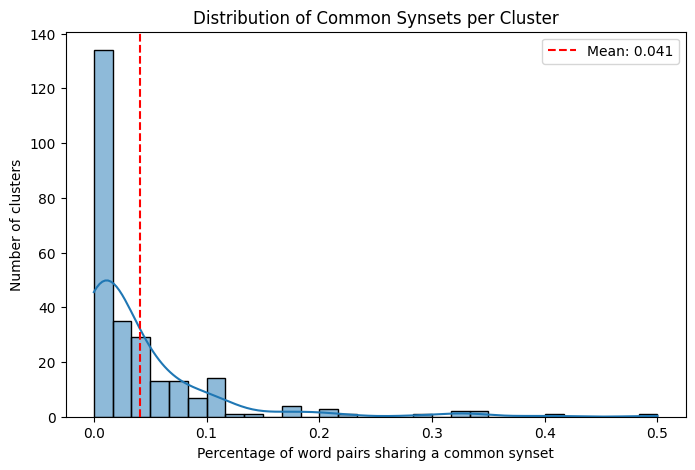

In [71]:
import seaborn as sns
mean_val = np.mean(list(common_synsets.values()))
plt.figure(figsize=(8, 5))
sns.histplot(list(common_synsets.values()), bins=30, kde=True)
plt.axvline(mean_val, color='red', linestyle='--', label=f"Mean: {mean_val:.3f}")
plt.xlabel("Percentage of word pairs sharing a common synset")
plt.ylabel("Number of clusters")
plt.title("Distribution of Common Synsets per Cluster")
plt.legend()
plt.show()

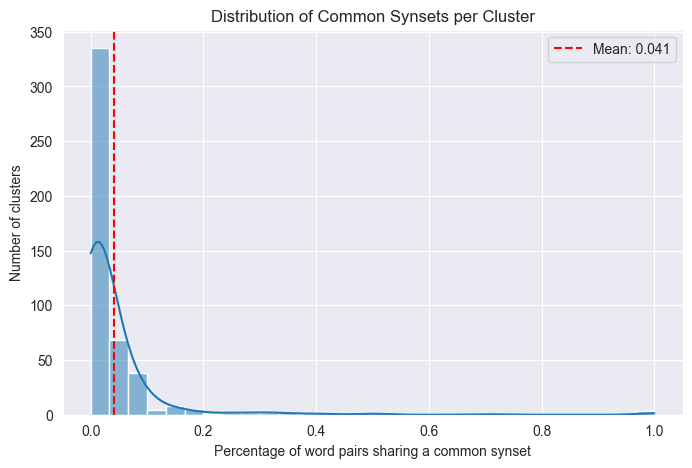

In [49]:
import seaborn as sns
mean_val = np.mean(list(common_synsets.values()))
plt.figure(figsize=(8, 5))
sns.histplot(list(common_synsets.values()), bins=30, kde=True)
plt.axvline(mean_val, color='red', linestyle='--', label=f"Mean: {mean_val:.3f}")
plt.xlabel("Percentage of word pairs sharing a common synset")
plt.ylabel("Number of clusters")
plt.title("Distribution of Common Synsets per Cluster")
plt.legend()
plt.show()

In [38]:
with open("clustering_results/semantic/common_synsets_600.csv", 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=["cluster_num","percentage common" ])
        writer.writeheader()
        
        # Write each row
        for tuple_key, inner_dict in common_synsets.items():
            row = {}
            
            # # Add tuple elements to the row
            # for i, element in enumerate(tuple_key):
            #     row[tuple_headers[i]] = element
            
            # Add values from inner dictionary
            # row.update(inner_dict)
            row["cluster_num"]=tuple_key
            row["percentage common"]=inner_dict

            
            writer.writerow(row)
    


In [50]:
related_scores = {}
for cluster_num in df_no_stop['cluster'].unique():
    if len(df_no_stop[df_no_stop['cluster']==cluster_num]['token'])<=10:
        continue
    print(len(df_no_stop[df_no_stop['cluster']==cluster_num]['token']))
    cluster_tokens = list(set(df_no_stop[df_no_stop['cluster']==cluster_num]['token']))
    # print(cluster_tokens)
    # common = [common_sysnset(a, b) for a in cluster_tokens for  b in cluster_tokens]
    common = []
    pairs = 0
    if len(cluster_tokens)>2:
        for i in range(0, len(cluster_tokens)):
            for j in range(i+1, len(cluster_tokens)):
                common+=[related(cluster_tokens[i], cluster_tokens[j])]
                pairs+=1
        common_count = sum(common)
        # pairs = len(cluster_tokens)**2
        print(f"cluster: {cluster_num}, size={len(cluster_tokens)}....{common_count}/{pairs}....{common_count/pairs}")
        related_scores[cluster_num] = common_count/pairs
    # break

252
cluster: 382, size=12....2/66....0.030303030303030304
54
cluster: 13, size=12....3/66....0.045454545454545456
23
cluster: 523, size=4....0/6....0.0
354
cluster: 254, size=74....802/2701....0.29692706405035174
1063
cluster: 248, size=46....204/1035....0.19710144927536233
962
cluster: 64, size=91....347/4095....0.08473748473748474
281
cluster: 9, size=74....57/2701....0.021103295075897817
601
cluster: 473, size=59....78/1711....0.04558737580362361
272
cluster: 439, size=12....12/66....0.18181818181818182
382
cluster: 332, size=62....134/1891....0.07086197778952935
205
cluster: 199, size=123....267/7503....0.03558576569372251
58
cluster: 55, size=53....75/1378....0.054426705370101594
86
cluster: 420, size=14....0/91....0.0
100
cluster: 512, size=18....5/153....0.032679738562091505
156
cluster: 0, size=45....42/990....0.04242424242424243
14
cluster: 135, size=13....36/78....0.46153846153846156
671
cluster: 38, size=25....11/300....0.03666666666666667
16
cluster: 125, size=13....2/78...

In [76]:
len(list(related_scores.values()))

261

In [77]:
np.average((list(related_scores.values())))

0.1294192244179763

In [51]:
len(list(related_scores.values()))

470

In [52]:
np.average((list(related_scores.values())))


0.1317434390159349

### Similarity Score

In [ ]:
# load model
with open(f"agg_models/agg_{classification}_50000_cosine_average_600.pkl", 'rb') as f:
    clf2 = pickle.load(f)

# clf2.get_params()
label_counts = np.bincount(clf2.labels_)
# plt.hist(np.bincount(clf2.labels_))

df_no_stop.loc[:,'cluster']= list(clf2.labels_)

In [24]:




from nltk.corpus import wordnet  
  
syn1 = wordnet.synsets('motivation')[0]  
syn2 = wordnet.synsets('motivate')[0]  
  
print ("hello name : ", syn1.name())  
print ("selling name : ", syn2.name())
print(syn1.path_similarity(syn2)  )
# print(syn1.lch_similarity(syn2)  )


hello name :  motivation.n.01
selling name :  motivate.v.01
0.125


In [25]:
path_sim = {}
for cluster_num in df_no_stop['cluster'].unique():
    cluster_tokens = list(set(df_no_stop[df_no_stop['cluster']==cluster_num]['token']))
    # common = [common_sysnset(a, b) for a in cluster_tokens for  b in cluster_tokens]
    path_similarities = []
    pairs = 0
    if len(cluster_tokens)>2:

        for i in range(0, len(cluster_tokens)):
            for j in range(i+1, len(cluster_tokens)):
                a_synsets = wordnet.synsets(cluster_tokens[i])
                b_synsets = wordnet.synsets(cluster_tokens[j])
                # print(f"{cluster_tokens[i]}  {cluster_tokens[j]} ")
                # print(a_synsets, b_synsets)
                possible_sim = [syn1.path_similarity(syn2)  for syn1 in a_synsets for syn2 in b_synsets]
                try:
                    path_similarities+=[max(possible_sim)]
                    pairs+=1

                except:
                    pairs+=0

        common_count = sum(path_similarities)
        # pairs = len(cluster_tokens)**2
        print(f"cluster: {cluster_num}.........{common_count/pairs}")
        path_sim[cluster_num] = common_count/pairs
    # break

cluster: 338.........0.23557117554513118
cluster: 184.........0.29597069597069564
cluster: 144.........0.22508557329108628
cluster: 69.........0.35062611895045953
cluster: 282.........0.42410256410256353
cluster: 274.........0.25374082395185477
cluster: 344.........0.17778130748187762
cluster: 292.........0.3066269147651075
cluster: 31.........0.19754183034193512
cluster: 30.........0.19424710748239685
cluster: 65.........0.3185185185185186
cluster: 182.........0.204021665202287
cluster: 157.........0.17012975403259722
cluster: 109.........0.29990731579612767
cluster: 299.........0.29000923302247045
cluster: 291.........0.3651515151515149
cluster: 295.........0.25260438652380507
cluster: 586.........0.34065934065934017
cluster: 502.........0.3969021653232182
cluster: 51.........0.3237894821228156
cluster: 360.........0.36036887089518715
cluster: 293.........0.3553024577843677
cluster: 41.........0.25684184728472503
cluster: 14.........0.28646593112694607
cluster: 275.........0.38441798

ZeroDivisionError: division by zero

In [53]:
with open("clustering_results/semantic/path_similarity_600.csv", 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=["cluster_num","average similarity" ])
        writer.writeheader()
        
        # Write each row
        for tuple_key, inner_dict in path_sim.items():
            row = {}
            
            # # Add tuple elements to the row
            # for i, element in enumerate(tuple_key):
            #     row[tuple_headers[i]] = element
            
            # Add values from inner dictionary
            # row.update(inner_dict)
            row["cluster_num"]=tuple_key
            row["average similarity"]=inner_dict

            
            writer.writerow(row)
    


In [26]:
np.mean(list(path_sim.values()))


0.2985637918869872

In [27]:
len(list(path_sim.values()))


164

### write concepts to CSVs

In [ ]:
clusternum = 400

In [ ]:
# load model
with open(f"agg_models/agg_{classification}_50000_cosine_average_{clusternum}.pkl", 'rb') as f:
    clf2 = pickle.load(f)

# clf2.get_params()
label_counts = np.bincount(clf2.labels_)
# plt.hist(np.bincount(clf2.labels_))

df_no_stop.loc[:,'cluster']= list(clf2.labels_)

In [ ]:
df_no_stop.to_csv(f"clustering_results/{classification}_concepts_{clusternum}.csv", index=False)